## Zhanqian

In [12]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
zhanqian = pd.read_csv(os.getcwd() + '/data/zhanqian.csv', names=['year', 'month', 'day', 'hour', 'minute', 'exp', 'cong', 'block', 'unknown'])
date_cols = ['year','month','day','hour','minute']
zhanqian['date'] = pd.to_datetime(zhanqian[date_cols])
zhanqian = zhanqian.set_index('date').drop(date_cols, axis=1)
for col in zhanqian.columns:
    zhanqian[col] = zhanqian[col].str.rstrip('%').astype('float') / 100.0

In [14]:
zhanqian.head()

,exp,cong,block,unknown
date,,,,
2018-01-09 16:40:00,0.6250,0.2500,0.1250,0.0000
2018-01-09 16:45:00,0.6250,0.3750,0.0000,0.0000
2018-01-09 16:50:00,0.7500,0.1250,0.1250,0.0000
2018-01-09 16:55:00,0.5000,0.3750,0.1250,0.0000
2018-01-09 17:00:00,0.5714,0.1429,0.1429,0.1428


In [49]:
zhanqian = zhanqian.resample('10Min').mean().bfill()
zhanqian.head()

,exp,cong,block,unknown
date,,,,
2018-01-09 16:40:00,0.62500,0.3125,0.06250,0.00000
2018-01-09 16:50:00,0.62500,0.2500,0.12500,0.00000
2018-01-09 17:00:00,0.64285,0.1429,0.14290,0.07145
2018-01-09 17:10:00,0.71430,0.2143,0.00000,0.07140
2018-01-09 17:20:00,0.47220,0.4097,0.11805,0.00005


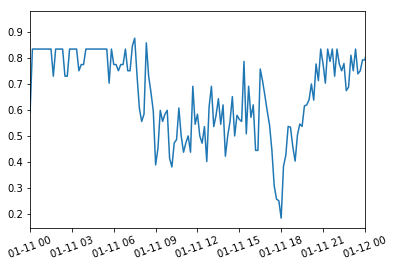

In [85]:
sns.lineplot(data=zhanqian['2018-01-11':'2018-01-12']['exp'])
plt.xlim(['2018-01-11', '2018-01-12'])
plt.xticks(rotation=20);

In [151]:
def hour_plot(df, ax, title):
    avg = df.groupby([df.index.hour]).mean()
    sns.lineplot(data=avg, ax=ax)
    ax.set_xlim(0, 23)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=20)
    ax.set_title(title)
    
def ten_min_plot(df, ax, title):
    avg = df.groupby([df.index.hour, df.index.minute]).mean()
    avg.index = avg.index.map('{0[0]}:{0[1]}'.format)
    avg.index = pd.to_datetime(avg.index,format='%H:%M').time
    sns.lineplot(data=avg, ax=ax)
    ax.set_xlim('00:00', '23:50')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=20)
    ax.set_xticks([f'{hr}:00' for hr in range(0,24,2)]);
    ax.set_title(title)

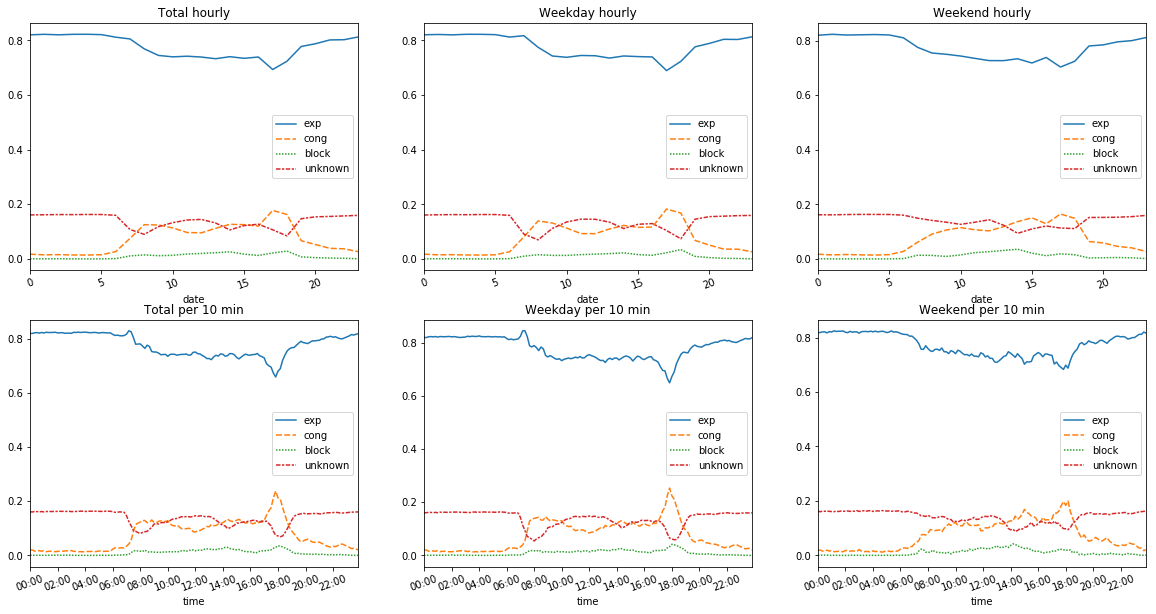

In [153]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
hour_plot(zhanqian, axes[0,0], 'Total hourly')
hour_plot(zhanqian[zhanqian.index.dayofweek < 5], axes[0,1], 'Weekday hourly')
hour_plot(zhanqian[zhanqian.index.dayofweek >= 5], axes[0,2], 'Weekend hourly')
ten_min_plot(zhanqian, axes[1,0], 'Total per 10 min')
ten_min_plot(zhanqian[zhanqian.index.dayofweek < 5], axes[1,1], 'Weekday per 10 min')
ten_min_plot(zhanqian[zhanqian.index.dayofweek >= 5], axes[1,2], 'Weekend per 10 min')